In [34]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import os
import json
import h5py
import flammkuchen as fl

import numpy as np
import pandas as pd

from pathlib import Path
import glob

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from preprocess_helpers import resample
from matplotlib.patches import Rectangle

In [66]:
def are_points_in_circle(points, a, b, r):
    # calculate the distance from each point to the center of the circle
    distances = (points[:, 0] - a)**2 + (points[:, 1] - b)**2

    # check if the distances are less than or equal to the square of the radius
    return distances <= r**2

def resample(df, df2):
    #df gets resampled to df2
    df1 =df.copy()
    resampled_df = pd.DataFrame(np.zeros((df2.shape[0], df1.shape[1])), columns=df1.columns)

    for i in df1.columns:
        interpolated_data = np.interp(df2.t, df1.t, df1[i])
        resampled_df[i] = interpolated_data

    return resampled_df

    This notebook reads in the orignal DeepLabCut file and applies 3 filters:

    (1) Edge filter for Arenas to exclude bouts at the edge 
    (2) DeepLabCut filter to just use well tracked frames for analysis

    Lastly it appends motor position to the dataframe.

## Read in Data

In [67]:
master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths, len(fish_paths)

([WindowsPath('//portulab.synology.me/data/Kata/testdata/Raw_Data/240423_f0')],
 1)

In [68]:
out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')

In [69]:
fish= 0
fish_path = fish_paths[fish]
fish_id =  fish_path.name 
# exp_name = Path(fish_path).parts[-2] 
exp_name = 'testfish'
exp_name, fish_id

('testfish', '240423_f0')

#### Read in Original DLC data

In [70]:
filename = list(fish_path.glob('*316000.h5*'))[0]
print (filename)
df_dlc= pd.read_hdf(filename,  header=[1, 2], index_col=0)
df_dlc = df_dlc['DLC_resnet50_dlc_2Dec12shuffle1_316000']

\\portulab.synology.me\data\Kata\testdata\Raw_Data\240423_f0\111814_videoDLC_resnet50_dlc_2Dec12shuffle1_316000.h5


In [71]:
df_dlc.head()

bodyparts left_eye_anterior                        left_eye_posterior  \
coords                    x           y likelihood                  x   
0                653.235962  549.867249   0.999891         647.881470   
1                654.368347  548.662109   0.999896         649.363464   
2                658.328735  546.076904   0.999923         653.924377   
3                662.999084  541.763550   0.999913         658.501892   
4                665.398071  538.954529   0.999740         661.073425   

bodyparts                        right_eye_anterior                         \
coords              y likelihood                  x           y likelihood   
0          519.701050   0.999758         626.027283  562.335266   0.999914   
1          518.040771   0.999851         626.644653  560.156250   0.999881   
2          515.740967   0.999905         629.848755  558.438354   0.999691   
3          511.638153   0.999953         635.091492  554.000916   0.999719   
4          508.786987   0.999960         638.392883  551.076233   0.999846   

bodyparts right_eye_posterior  ...     tail_1      tail_2              \
coords                      x  ... likelihood           x           y   
0                  602.901550  ...   0.980895  550.919128  328.616638   
1                  603.670349  ...   0.979551  553.069946  323.318237   
2                  607.012573  ...   0.978947  554.070068  322.324982   
3                  612.348083  ...   0.985706  552.845642  316.216949   
4                  615.801147  ...   0.982587  548.529724  316.224487   

bodyparts                 tail_3                             tail_4  \
coords    likelihood           x           y likelihood           x   
0           0.962139  505.450104  277.608337   0.923167  439.471039   
1           0.921706  515.273926  267.767639   0.920416  444.348114   
2           0.863583  524.936035  261.235168   0.891188  461.540009   
3           0.945818  530.994629  256.552765   0.936800  476.081390   
4           0.965356  528.076477  252.677872   0.929202  485.563690   

bodyparts                         
coords              y likelihood  
0          239.365433   0.970800  
1          245.641525   0.980387  
2          236.261642   0.980165  
3          216.947006   0.973007  
4          199.774689   0.969979  

[5 rows x 42 columns]

#### Resample motor log to camera frame rate 

In [72]:
motor_path = list(fish_path.glob('*motor_log.hdf5*'))[0]
motor_path

WindowsPath('//portulab.synology.me/data/Kata/testdata/Raw_Data/240423_f0/111814_motor_log.hdf5')

In [73]:
motor_log = pd.read_hdf(motor_path)

In [74]:
tp_vid = np.linspace(motor_log.t.iloc[0], motor_log.t.iloc[-1], df_dlc.shape[0])
df_dlc = df_dlc.copy()
df_dlc['t'] = tp_vid  

In [75]:
resampled = resample(motor_log, df_dlc)
print (resampled.shape, motor_log.shape, df_dlc.shape)

(95423, 8) (111024, 8) (95423, 43)


##  (1) Add edge filter to DLC dataframe

### Rechtangular arena

In [76]:
# mask  = fl.load(out_path/'{}_mask.csv'.format(exp_name))

# # for rectangular mask
# margin = mask[4]
# x_lim_neg = mask[0]
# x_lim_pos = mask[1]
# y_lim_neg = mask[2]
# y_lim_pos = mask[3]
# mask

In [77]:
# x_lim_pos_edge = x_lim_pos - x_lim_neg
# y_lim_pos_edge = y_lim_pos - y_lim_neg

# fig, ax = plt.subplots()
# ax.plot(resampled.x, resampled.y, label='original')
# ax.add_patch(Rectangle((x_lim_neg, y_lim_neg), x_lim_pos_edge, y_lim_pos_edge, #x, y, widht, height
#              edgecolor = 'pink',
#              facecolor = 'blue',
#              fill=False,
# #              angle=-0.5,
#              lw=6))
# plt.title('arena mask')
# plt.savefig(out_path/'plots'/'{}_arena_mask.png'.format(fish_id))

In [78]:
# filtered_x = resampled[(resampled.x >= x_lim_neg + margin ) & (resampled.x <= x_lim_pos - margin )]
# filtered = filtered_x[(resampled.y >= y_lim_neg + margin ) & (resampled.y <= y_lim_pos - margin )]
# indixes_ok = filtered.index.values

# to_fill = np.full(resampled.shape[0], False)
# to_fill[indixes_ok] = True
# to_fill

In [79]:
# df_dlc.insert(0, ("edge_filter", "ok"), to_fill)

### Round arena

In [80]:
mask  = fl.load(out_path /'filtered'/ '{}_mask.csv'.format(exp_name))
print (mask)

#for round marks
margin = mask[-1]
center_x = mask[0]
center_y = mask[1]
radius = mask[2] 

[2.5, 0, 30, 1]


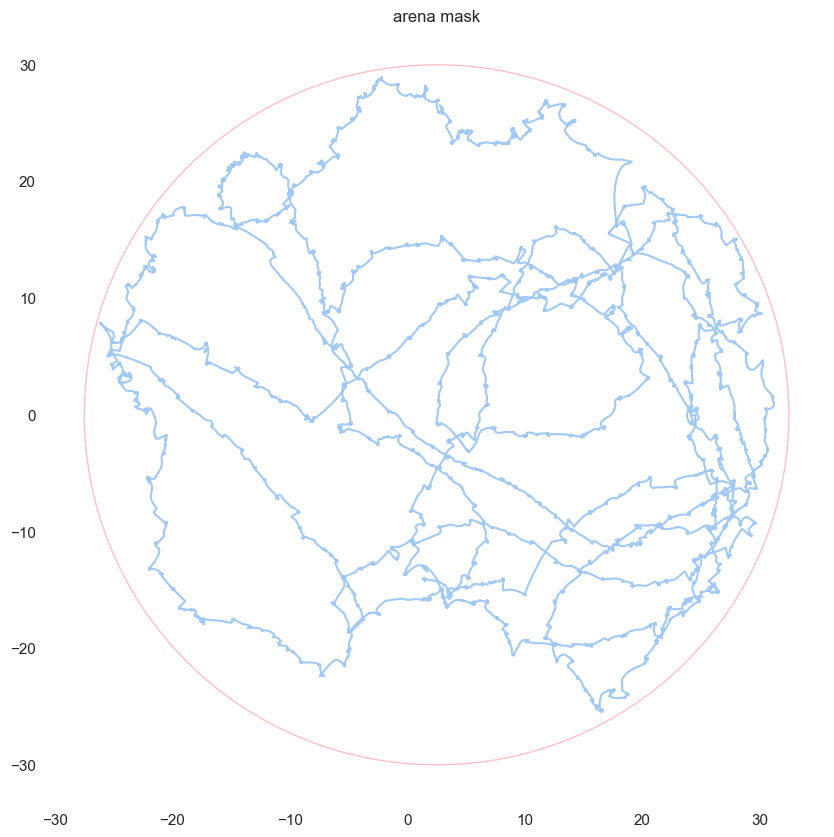

In [81]:
sns.set_theme(style="white", palette="pastel")
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(resampled.x, resampled.y, label='original')

circle = plt.Circle((center_x, center_y), radius, color='pink', fill=False)
ax.add_patch(circle)

plt.title('arena mask')
sns.despine(top=True, right=True, left=True, bottom=True)

plt.savefig(out_path/'plots'/'{}_arena_mask.png'.format(fish_id))

In [82]:
points = np.column_stack((resampled.x,resampled.y))
to_fill = are_points_in_circle(points, center_x, center_y, radius)


In [83]:
df_dlc.insert(0, ("edge_filter", "ok"), to_fill)

### Insert data motor data

In [84]:
#Extract angles
motor_x = resampled.x.values.astype('float')
motor_y = resampled.y.values.astype('float')
motor_z = resampled.z.values.astype('float')
motor_x.shape, motor_y.shape, df_dlc.shape

((95423,), (95423,), (95423, 44))

In [85]:
df_dlc.insert(0, ("motor", "x"), motor_x.T)
df_dlc.insert(0, ("motor", "y"), motor_y.T)
df_dlc.insert(0, ("motor", "z"), motor_z.T)

## (2) Apply Deeplabcut Filter to data

In [86]:
thresh = 0.99

In [87]:
df_orig = df_dlc.copy()
df_tmp = df_dlc.copy()
percentile = df_dlc[df_dlc.body.likelihood >=thresh].shape[0]/df_orig.shape[0]
print ('right now we keep {} % of data'.format(np.round(percentile*100, 3)))

right now we keep 99.794 % of data


In [88]:
good_dlc_tracking = df_dlc[df_dlc.body.likelihood >=thresh].index.values
good_dlc_tracking

array([    0,     1,     2, ..., 95420, 95421, 95422], dtype=int64)

In [89]:
to_fill = np.full(df_tmp.shape[0],-1)
to_fill[good_dlc_tracking] = 1
to_fill

array([1, 1, 1, ..., 1, 1, 1])

In [90]:
df_tmp.insert(0, ("DLC_filter", "pos"), to_fill)

### Save new DLC

In [91]:
out_path_dlc = Path(out_path/ '{}_DLC.csv'.format(fish_id)) 
out_path_dlc

WindowsPath('//portulab.synology.me/data/Kata/testdata/Processed_Data/240423_f0_DLC.csv')

In [92]:
df_tmp.to_csv(out_path_dlc)

#### How to read it back in

In [93]:
# test = pd.read_csv(out_path, header=[0,1])

In [94]:
# test